# EDA of Restaurant Region Information

- Region (Feature Engineering)
- Walking Distance from Station Exits
- Restaurant Within Malls

## 1. Data Preparation

In [1]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re

# Geosptial Analysis
import geopandas as gpd #conda install geopandas
# conda install -c conda-forge nbformat
import plotly.express as px #conda install -c plotly plotly_express
from plotly.express import choropleth_mapbox
from shapely.geometry import shape, Point
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# python script containing mapbox token (not uploaded on GitHub)
try:
    from tokens import mapbox_token
except:
    mapbox_token = '############### USE OWN MAPBOX TOKEN ###############'

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

### Loading of Datasets

In [3]:
df_restaurant = pd.read_csv("data/extended_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_distance_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')

In [7]:
subset_columns = [
    'name',
    'address',
    'region',
    'latitude',
    'longitude',
    'overall_rating',
    'num_of_reviews',
    'url'
]

df_restaurant_subset = df_restaurant[subset_columns].copy()
df_restaurant_subset = df_restaurant_subset.merge(df_is_in_mall[['url', 'is_in_mall', 'mall']], on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')

### Drop Missing Ratings and Number of Reviews < 3

In [8]:
############# Drop Ratings = -1
df_restaurant_subset = df_restaurant_subset[df_restaurant_subset['overall_rating'] != -1].copy()

print('Percentage of Restaurants:')
df_restaurant_subset['overall_rating'].value_counts().sort_index() / len(df_restaurant_subset) * 100 

Percentage of Restaurants:


1.0     0.111235
1.5     0.305895
2.0     0.834260
2.5     2.419355
3.0     9.246385
3.5    24.680200
4.0    38.000556
4.5    20.647942
5.0     3.754171
Name: overall_rating, dtype: float64

In [9]:
############# Drop Num_of_reviews < 3
df_num_of_reviews_capped = df_restaurant_subset[df_restaurant_subset['num_of_reviews'] >= 3].copy()

########### Potentially: 4.5 / 5.0: Outstanding, 4.0: Average, 3.5 and below: Below Average
print(f"Total Observations: {len(df_num_of_reviews_capped)}")
print(f"Below Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] < 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] == 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Outstanding: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] >= 4.5]) * 100 / len(df_num_of_reviews_capped)}%")

Total Observations: 7192
Below Average: 37.59733036707453%
Average: 38.00055617352614%
Outstanding: 24.40211345939933%


### Dropping Rows with missing Walking Distance

In [10]:
print(f"Total Rows: {len(df_num_of_reviews_capped)}")
print(f"Good Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] > 100])}")
print(f"Bad Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] < 100])}")
print(f"Missing Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'].isna()])}")
print(f"Missing Walking Distance: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['walking_distance'].isna()])}")

Total Rows: 7192
Good Geolocations: 7192
Bad Geolocations: 0
Missing Geolocations: 0
Missing Walking Distance: 0


In [11]:
df_num_of_reviews_capped = df_num_of_reviews_capped.dropna(subset=['walking_distance'])

## 2. Exploring Region feature scraped from TripAdvisor

- Region obtained from TripAdvisor is identified as a Problematic Feature
- The regions labeled are inconsistent (relative to the restaurant's true geographical location). For example a restaurant located in Marina Bay Sands could be assigned a region 'Marina Centre', and another could be assigned 'Central Area/City Area' 

In [12]:
print(f"Total Number of TripAdvisor Regions: {len(df_num_of_reviews_capped['region'].value_counts())}")
print("Percentage of Restaurants in these regions:")
print(df_num_of_reviews_capped['region'].value_counts().head(10) / len(df_num_of_reviews_capped) * 100)

Total Number of TripAdvisor Regions: 22
Percentage of Restaurants in these regions:
OUTRAM                           9.649611
NEWTON, ORCHARD                  9.343715
ROCHOR                           8.384316
SINGAPORE RIVER                  6.813126
DOWNTOWN                         5.909344
NORTH-EAST REGION                5.659066
BUGIS, CITY HALL                 5.422692
WEST REGION                      5.380979
BUKIT MERAH, SOUTHERN ISLANDS    5.214127
MARINA CENTRE                    4.171301
Name: region, dtype: float64


## 3. Using Geospatial Information to engineer a "new" Region feature

### Convert dataframe into a GeoDataFrame

In [13]:
gdf_restaurant = gpd.GeoDataFrame(df_num_of_reviews_capped, geometry= gpd.points_from_xy(df_num_of_reviews_capped['longitude'], df_num_of_reviews_capped['latitude']), crs='epsg:4326')

### Loading a Subzones Shapefile Data
- Containing Geographical Boundary in Singapore (defined by Urban Redevelopment Authority URA)
- 3 Levels of Boundary: Area (e.g. East, West), Town (e.g. Bishan), District (e.g. Marymount)

In [14]:
gdf_subzones = gpd.read_file('data/singapore_subzones_2019.geojson', crs='epsg:4326')
gdf_subzones['extracted_description'] = gdf_subzones['Description'].apply(
    lambda x: re.findall("(?<=<td>)[\w*\s*\-*]*\w+(?=</td>)", x)
)

def extract_district(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[1]
        else:
            np.nan
    else:
        return np.nan

def extract_town(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[4]
        else:
            return x[3]
    else:
        return np.nan

def extract_region(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[6]
        else:
            return x[5]
    else:
        return np.nan

gdf_subzones['district'] = gdf_subzones['extracted_description'].apply(lambda x: extract_district(x))
gdf_subzones['town'] = gdf_subzones['extracted_description'].apply(lambda x: extract_town(x))
gdf_subzones['area'] = gdf_subzones['extracted_description'].apply(lambda x: extract_region(x))        

gdf_subzones.drop(columns=['Name', 'Description', 'extracted_description'], inplace=True)

### Geospatial Join of Region Dataset to map District/Town/Area that each restaurant is located in

In [15]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_subzones,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)

### Handling Missing District/Town/Area
- It is identified from Geospatial Visualisation that the restaurants that are not mapped to any geographical boundaries are located offshore. Hence the district/town/area of these restaurants are imputed based on the nearest boundary from the restaurant

In [16]:
gdf_restaurant_missing_location = gdf_restaurant[gdf_restaurant['area'].isna()].copy()
gdf_restaurant_missing_location

,name,address,region,latitude,longitude,overall_rating,num_of_reviews,url,is_in_mall,mall,walking_distance,walking_duration,station_name,station_line_color,distance,geometry,district,town,area
2515,Goldenbeach Seafood Paradise,907 East Coast Road #01-01 Springvale Springva...,CHANGI,1.391251,103.97471,4.0,27,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,6161.8,4436.4,PASIR RIS MRT STATION,GREEN,3481.244390,POINT (103.97471 1.39125),NaN,NaN,NaN
2731,Rasa Istimewa,"6A Admiralty Road West Waterfront Park, Singap...",NORTH REGION,1.453914,103.77774,3.5,37,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,2895.9,2085.0,WOODLANDS MRT STATION,RED,2116.644183,POINT (103.77774 1.45391),NaN,NaN,NaN
2792,Patro's Sports Bar & Restaurant,920 East Coast Parkway Parkland Green #01-18/1...,MARINA BAY,1.298121,103.90860,3.5,52,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,3001.7,2161.2,EUNOS MRT STATION,GREEN,2441.963490,POINT (103.90860 1.29812),NaN,NaN,NaN
4968,Stewords Riverboat,31 Marina Coastal Drive Marina South Pier Bert...,MARINA BAY,1.270886,103.86388,3.5,7,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,52.4,37.8,MARINA SOUTH PIER MRT STATION,RED,69.574040,POINT (103.86388 1.27089),NaN,NaN,NaN


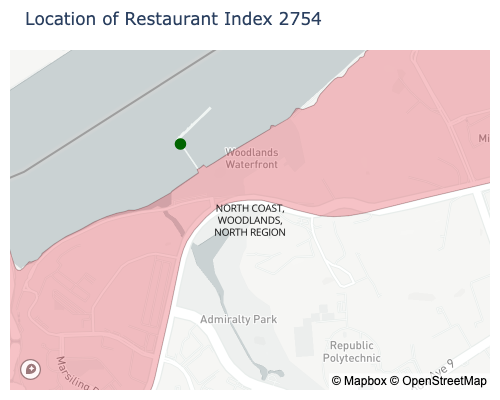

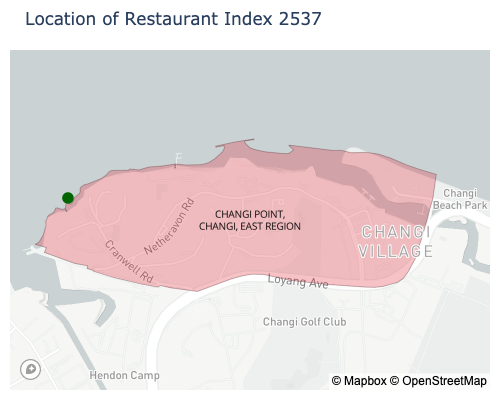

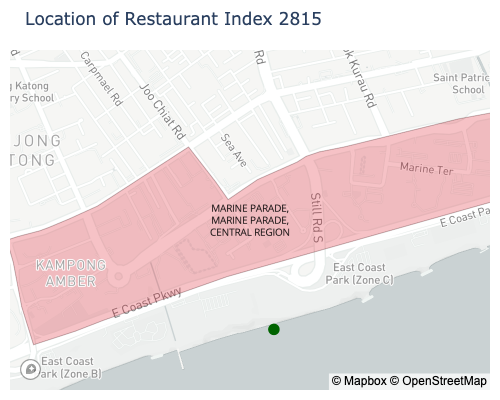

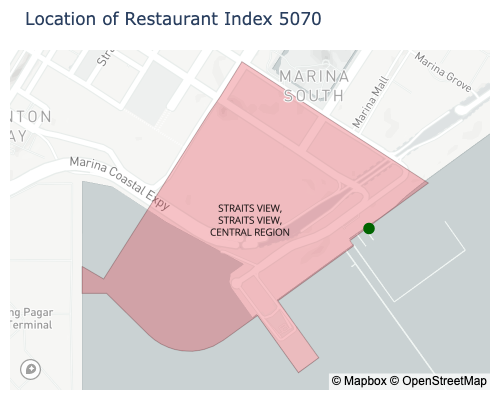

In [17]:
for res_id, region_id in [(2754, 323), (2537, 258), (2815, 93), (5070, 12)]:
    gdf_subset_subzones = gdf_subzones[gdf_subzones.index == region_id]
    fig = px.choropleth_mapbox(
        gdf_subset_subzones,
        geojson=gdf_subset_subzones.geometry,
        locations=gdf_subset_subzones.index,
        opacity=0.3,
        color=gdf_subset_subzones.district,
        color_discrete_map={gdf_subset_subzones.loc[:,'district'].iloc[0]: hex_colors[3]},
        zoom=13, # 11.2 for CBD  
        labels={'district': 'District', 'town': 'Town', 'area': 'Area'},
    )

    fig.update_traces(showlegend=False)

    fig2 = go.Figure(go.Scattermapbox(
        mode="markers",
        lat=gdf_restaurant_missing_location['latitude'],
        lon=gdf_restaurant_missing_location['longitude'],
        marker= {"size": 12, "color": "darkgreen"},
    ))

    fig3 = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_subset_subzones.centroid.y,
        lon=gdf_subset_subzones.centroid.x,
        text=f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
    ))

    fig3.update_layout(
        width=500,
        height=400,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= gdf_subset_subzones.iloc[0,:].geometry.centroid.y,
                lon= gdf_subset_subzones.iloc[0,:].geometry.centroid.x,        
            ), zoom=14),        
        title=f"Location of Restaurant Index {res_id}",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
        mapbox_accesstoken=mapbox_token,
        # mapbox= {'style': 'outdoors'},
        showlegend=False,        
    )

    fig3.update_traces(
        showlegend=False,
        mode="text", 
        text= 
        f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
        textfont=dict(size=10, color='black')
    )

    fig3.add_trace(fig2.data[0])
    fig3.add_trace(fig.data[0])

    fig3.show("png")

In [18]:
gdf_restaurant.loc[2537, 'district'] = 'CHANGI POINT'
gdf_restaurant.loc[2537, 'town'] = 'CHANGI'
gdf_restaurant.loc[2537, 'area'] = 'EAST REGION'

gdf_restaurant.loc[2754, 'district'] = 'NORTH COAST'
gdf_restaurant.loc[2754, 'town'] = 'WOODLANDS'
gdf_restaurant.loc[2754, 'area'] = 'NORTH REGION'

gdf_restaurant.loc[2815, 'district'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'town'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'area'] = 'CENTRAL REGION'

gdf_restaurant.loc[5070, 'district'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'town'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'area'] = 'CENTRAL REGION'

### Visualising Number of Restaurants in each Area
- With the 3 layers of boundaries, we will inspect layer by layer to identify the boundary best suited for our project, beginning with the largest boundary, Area (North Region, North-East Region, East Region, Central Region, West Region)
- We will visualise the number of restaurants in our dataset within each boundary. We aim to ensure that the new "region" we engineered is fairly distributed and not skewed towards any particular label

In [19]:
# aggregating District boundaries to form Area boundary

df_region_area_rating = gdf_restaurant.groupby(['area']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_area_rating.columns = df_region_area_rating.columns.droplevel(1)
df_region_area_rating.reset_index(drop=False, inplace=True)
df_region_area_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_area = gdf_subzones.dissolve(by='area').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_area_rating = df_region_area_rating.merge(gdf_area, on='area', how='left')
gdf_region_area_rating = gpd.GeoDataFrame(df_region_area_rating, geometry='geometry', crs='epsg:4326')

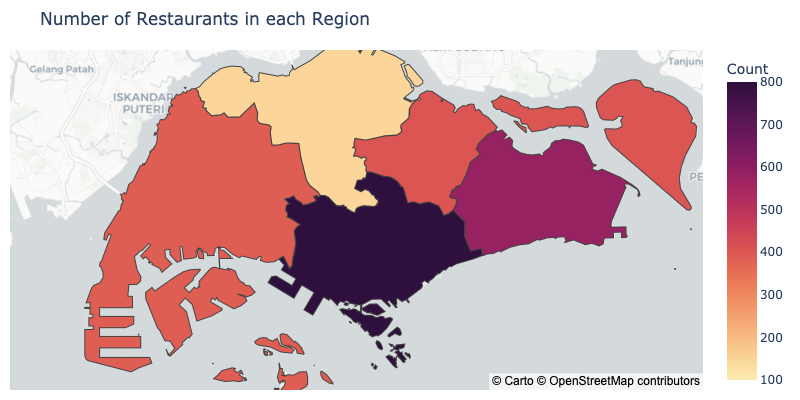

In [20]:
fig = px.choropleth_mapbox(
    gdf_region_area_rating,
    geojson = gdf_region_area_rating.geometry,
    locations = gdf_region_area_rating.index,
    labels={
        'num_of_restaurants': 'Count'
    },
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,800),
    hover_data=['area'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

<strong>Observations:</strong>

- The Central Region has overwhelmingly more restaurants than the other regions. 
- The East Region has the second most number of restaurants and is significantly greater than that of the West and North-East Region
- The North Region has the least region among all areas

### Number of Restaurants within the Towns in the Central and East Regions
- Due to the unequal distribution as shown above, we will like to "break" the Central and East region into smaller boundaries so that the sub-boundaries have a number of restaurants that is closer to that of the North, North-East and West Regions.
- We will next look into the Town boundaries of the Central and East Regions.

In [21]:
# aggregating District boundaries to form Town boundary

df_region_town_rating = gdf_restaurant.groupby(['town']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_town_rating.columns = df_region_town_rating.columns.droplevel(1)
df_region_town_rating.reset_index(drop=False, inplace=True)
df_region_town_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_town = gdf_subzones.dissolve(by='town').reset_index(drop=False)[['town', 'area', 'geometry']]
gdf_region_town_rating = df_region_town_rating.merge(gdf_town, on='town', how='left')
gdf_region_town_rating = gpd.GeoDataFrame(gdf_region_town_rating, geometry='geometry', crs='epsg:4326')

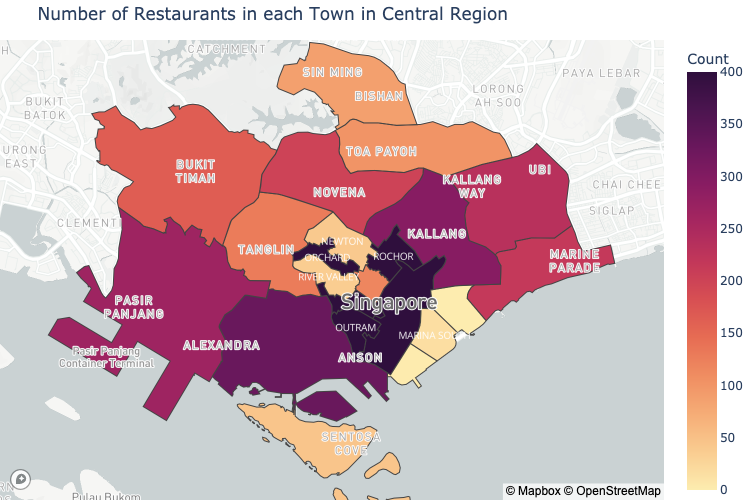

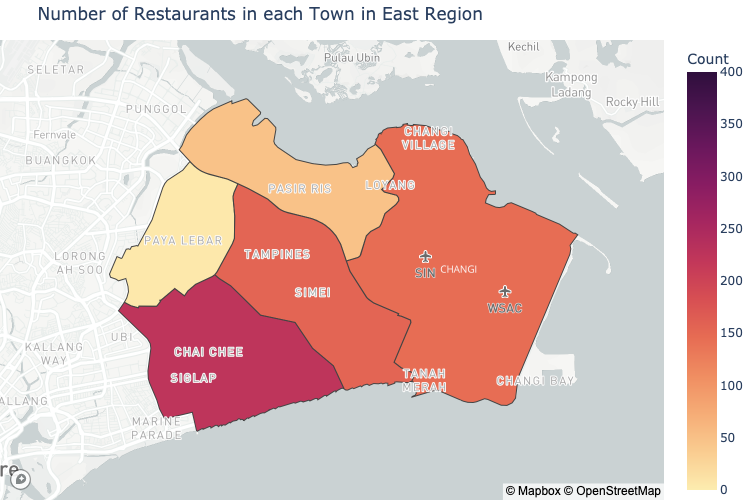

In [22]:
for i in [('CENTRAL REGION', 1.3, 103.835, 'Central'), ('EAST REGION', 1.35, 103.96, 'East')]:
    gdf_region_town_rating_subset = gdf_region_town_rating[gdf_region_town_rating['area'] == i[0]].copy()
    fig_text = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_region_town_rating_subset.centroid.y,
        lon=gdf_region_town_rating_subset.centroid.x,
        text=gdf_region_town_rating_subset['town'],
        textfont=dict(size=10, color='white')
    ))

    fig = px.choropleth_mapbox(
        gdf_region_town_rating_subset,
        geojson = gdf_region_town_rating_subset.geometry,
        locations = gdf_region_town_rating_subset.index,
        color='num_of_restaurants',
        color_continuous_scale='matter',
        range_color=(0,400),
        hover_data=['town', 'area'],
        labels={'num_of_restaurants': 'Count'}
    )    

    fig.update_layout(
        width=750,
        height=500,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= i[1],
                lon= i[2],
            ), zoom=11.2),
        mapbox_accesstoken=mapbox_token,
        title=f"Number of Restaurants in each Town in {i[3]} Region",
        margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
        showlegend=False,        
    )

    fig.add_traces(fig_text.data[0])
    fig.show("png")

In [23]:
gdf_region_town_rating_central = gdf_region_town_rating[gdf_region_town_rating['area'] == 'CENTRAL REGION'].copy()
gdf_region_town_rating_central.sort_values(['num_of_restaurants'], ascending=False, inplace=True)
gdf_region_town_rating_central.reset_index(drop=True, inplace=True)

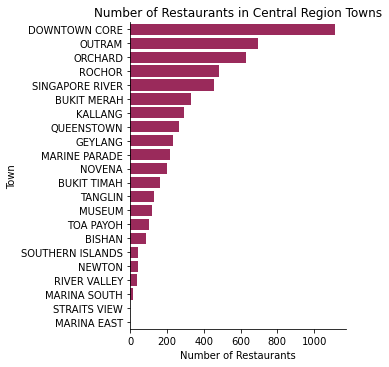

In [24]:
ax = sns.catplot(
    y = 'town',
    x = 'num_of_restaurants',
    data = gdf_region_town_rating_central,
    kind='bar',
    color=hex_colors[2]
)

ax.fig.gca().set_title("Number of Restaurants in Central Region Towns")
ax.fig.gca().set_ylabel("Town")
ax.fig.gca().set_xlabel("Number of Restaurants")
plt.show()

<strong>Observations:</strong>

- In the Central Region, Downtown Core has a much larger number of restaurants than the other towns. We will take a closer look at the districts within the Downtown Core next.
- For towns that have very few counts such as Straits View and Marina East, they will be "merged" into towns.
- In the East Region, Bedok has the largest number of restaurants. The differences in counts across the towns is smaller than that of Central Region. Paya lebar and Pasir Ris will be merged into the Tampines town as they have slightly fewer counts of restaurants.

### Further Breaking Down Downtown Core into Districts

In [25]:
df_region_district_rating = gdf_restaurant.groupby(['district']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_district_rating.columns = df_region_district_rating.columns.droplevel(1)
df_region_district_rating.reset_index(drop=False, inplace=True)
df_region_district_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_district = gdf_subzones.dissolve(by='district').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_district_rating = df_region_district_rating.merge(gdf_district, on='district', how='left')
gdf_region_district_rating = gpd.GeoDataFrame(df_region_district_rating, geometry='geometry', crs='epsg:4326')

gdf_region_district_rating_downtown = gdf_region_district_rating[gdf_region_district_rating['town'] == 'DOWNTOWN CORE']

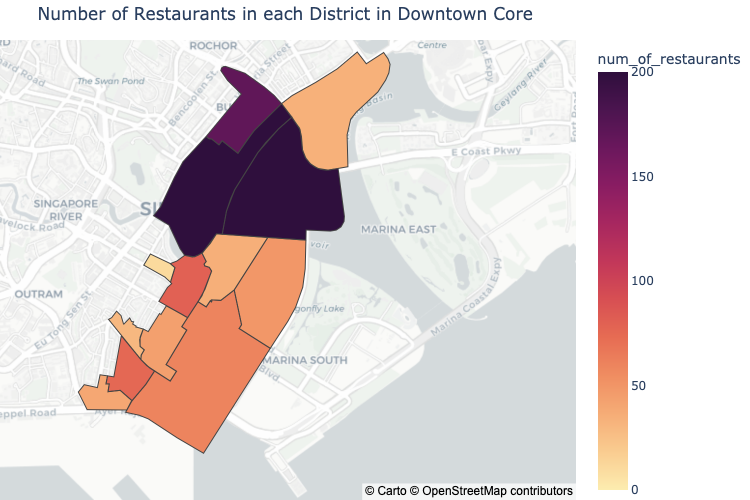

In [26]:
fig = px.choropleth_mapbox(
    gdf_region_district_rating_downtown,
    geojson = gdf_region_district_rating_downtown.geometry,
    locations = gdf_region_district_rating_downtown.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(0,200),
    hover_data=['town', 'area', 'district'],
    width=750,
    height=500,
    center= {
        'lat': 1.285,
        'lon': 103.86
    },
    zoom=12.95 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each District in Downtown Core",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

# BUGIS + CITY HALL
# MARINA CENTRE + NICOLL
# REMAINING --> Downtown Core

<strong>Observations:</strong>

- The Districts in the northern regions have more restaurants than those of the southern region. The districts in the southern region will then be grouped together.

### Grouping District/Towns into "New" Region Lables

In [27]:
# ---------------------------------------------- #
gdf_town_paya_lebar_tampines_pasir_ris = gdf_town[gdf_town['town'].isin([
    'PAYA LEBAR', 'TAMPINES', 'PASIR RIS'])]

gdf_town_paya_lebar_tampines_pasir_ris = gdf_town_paya_lebar_tampines_pasir_ris.dissolve('area').reset_index(drop=False)
gdf_town_paya_lebar_tampines_pasir_ris.loc[0, 'town'] = 'PAYA LEBAR, TAMPINES, PASIR RIS'

# ---------------------------------------------- #
gdf_town_bishan_toa_payoh = gdf_town[gdf_town['town'].isin([
    'BISHAN', 'TOA PAYOH'])]

gdf_town_bishan_toa_payoh = gdf_town_bishan_toa_payoh.dissolve('area').reset_index(drop=False)
gdf_town_bishan_toa_payoh.loc[0, 'town'] = 'BISHAN, TOA PAYOH'

# ---------------------------------------------- #
gdf_town_rochor = gdf_town[gdf_town['town'].isin([
    'MUSEUM', 'ROCHOR'])]

gdf_town_rochor = gdf_town_rochor.dissolve('area').reset_index(drop=False)
gdf_town_rochor.loc[0, 'town'] = 'ROCHOR'

# ---------------------------------------------- #
gdf_town_singapore_river = gdf_town[gdf_town['town'].isin([
    'RIVER VALLEY', 'SINGAPORE RIVER'])]

gdf_town_singapore_river = gdf_town_singapore_river.dissolve('area').reset_index(drop=False)
gdf_town_singapore_river.loc[0, 'town'] = 'SINGAPORE RIVER'

# ---------------------------------------------- #
gdf_town_newtown_orchard = gdf_town[gdf_town['town'].isin([
    'NEWTON', 'ORCHARD'])]

gdf_town_newtown_orchard = gdf_town_newtown_orchard.dissolve('area').reset_index(drop=False)
gdf_town_newtown_orchard.loc[0, 'town'] = 'NEWTON, ORCHARD'

# ---------------------------------------------- #
gdf_town_bukit_merah_southern_islands = gdf_town[gdf_town['town'].isin([
    'BUKIT MERAH', 'SOUTHERN ISLANDS'])]

gdf_town_bukit_merah_southern_islands = gdf_town_bukit_merah_southern_islands.dissolve('area').reset_index(drop=False)
gdf_town_bukit_merah_southern_islands.loc[0, 'town'] = 'BUKIT MERAH, SOUTHERN ISLANDS'

# ---------------------------------------------- #
gdf_town_marina_bay = gdf_town[gdf_town['town'].isin([
    'MARINE PARADE', 'MARINA EAST', 'MARINA SOUTH', 'STRAITS VIEW'])]

gdf_town_marina_bay = gdf_town_marina_bay.dissolve('area').reset_index(drop=False)
gdf_town_marina_bay.loc[0, 'town'] = 'MARINA BAY'

# ---------------------------------------------- #
gdf_district_bugis_city_hall = gdf_district[gdf_district['district'].isin([
    'BUGIS', 'CITY HALL'])]

gdf_district_bugis_city_hall = gdf_district_bugis_city_hall.dissolve('area').reset_index(drop=False)
gdf_district_bugis_city_hall.loc[0, 'district'] = 'BUGIS, CITY HALL'

# ---------------------------------------------- #
gdf_district_marina_centre = gdf_district[gdf_district['district'].isin([
    'NICOLL', 'MARINA CENTRE'])]

gdf_district_marina_centre = gdf_district_marina_centre.dissolve('area').reset_index(drop=False)
gdf_district_marina_centre.loc[0, 'district'] = 'MARINA CENTRE'

# ---------------------------------------------- #
gdf_district_downtown = gdf_district[
    ~(gdf_district['district'].isin(['NICOLL', 'MARINA CENTRE', 'BUGIS', 'CITY HALL'])) &
    (gdf_district['town'] == 'DOWNTOWN CORE')
]

gdf_district_downtown = gdf_district_downtown.dissolve('area').reset_index(drop=False)
gdf_district_downtown.loc[0, 'district'] = 'DOWNTOWN'

### Existing District/Town/Area

In [28]:
gdf_area_excluding_central_east = gdf_area[~gdf_area['area'].isin(['EAST REGION', 'CENTRAL REGION'])]
gdf_area_excluding_central_east = gdf_area_excluding_central_east[['geometry', 'area']].rename(columns={'area': 'new_region_feature'})

# ---------------------------------------------- #
gdf_town_changi_bedok = gdf_town[gdf_town['town'].isin([
                                'CHANGI', 'BEDOK'])]

gdf_town_changi_bedok = gdf_town_changi_bedok[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})                               

# ---------------------------------------------- #
gdf_town_central =gdf_town[
    (gdf_town['area'] == 'CENTRAL REGION') &
    ~(gdf_town['town'].isin([
        'BISHAN', 'TOA PAYOH', 'MUSEUM', 'ROCHOR', 'RIVER VALLEY',
        'SINGAPORE RIVER', 'NEWTON', 'ORCHARD', 'MARINE PARADE', 'MARINA EAST',
        'MARINA SOUTH', 'STRAITS VIEW', 'BUKIT MERAH', 'SOUTHERN ISLANDS','DOWNTOWN CORE'
    ]))
]

gdf_town_central = gdf_town_central[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})

### Creation of New Feature and Merging into Restaurant Data

In [29]:
gdf_new_region = pd.concat([
    gdf_area_excluding_central_east,
    gdf_town_changi_bedok,
    gdf_town_central,
    gdf_town_paya_lebar_tampines_pasir_ris[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bishan_toa_payoh[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_rochor[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_singapore_river[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_newtown_orchard[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bukit_merah_southern_islands[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_marina_bay[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_district_bugis_city_hall[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_marina_centre[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_downtown[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
])

gdf_new_region.reset_index(drop=True, inplace=True)

In [30]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_new_region,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)
gdf_restaurant.loc[2537, 'new_region_feature'] = 'CHANGI'
gdf_restaurant.loc[2754, 'new_region_feature'] = 'NORTH REGION'
gdf_restaurant.loc[2815, 'new_region_feature'] = 'MARINA BAY'
gdf_restaurant.loc[5070, 'new_region_feature'] = 'MARINA BAY'

In [31]:
df_new_region = gdf_restaurant.groupby(['new_region_feature']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_new_region.columns = df_new_region.columns.droplevel(1)
df_new_region.reset_index(drop=False, inplace=True)
df_new_region.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)

In [32]:
gdf_new_region = gdf_new_region.merge(df_new_region, on='new_region_feature', how='left')

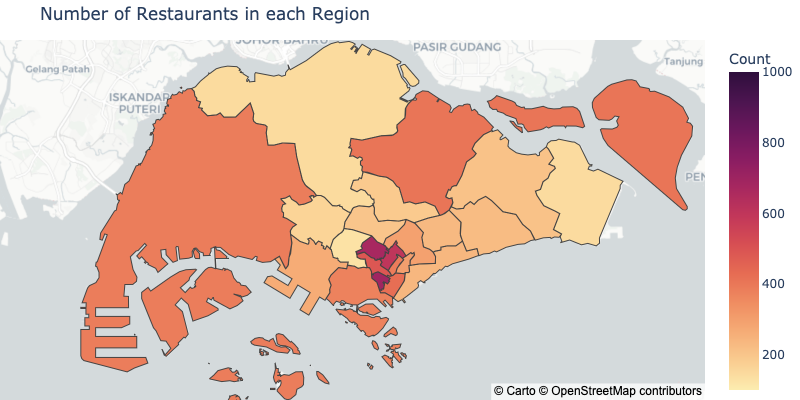

In [33]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,1000),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'num_of_restaurants': 'Count'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

## 4. EDA on Region

### EDA on Region and Rating

#### Bucketing Rating into different groups to see Geographical Distribution of Restaurants island-wide

In [34]:
rating_dct = {
    1: 'Subpar',
    1.5: 'Subpar',
    2: 'Subpar',
    2.5: 'Subpar',
    3: 'Subpar',
    3.5: 'Subpar',
    4: 'Average',
    4.5: 'Outstanding',
    5: 'Outstanding'

}

gdf_restaurant['overall_rating_categorical'] = gdf_restaurant['overall_rating'].map(rating_dct)

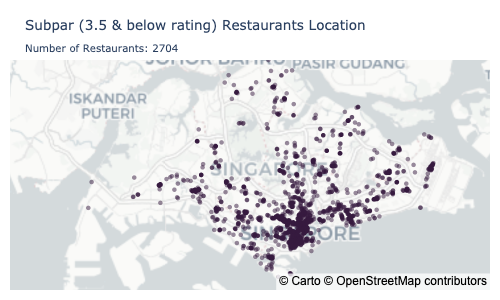

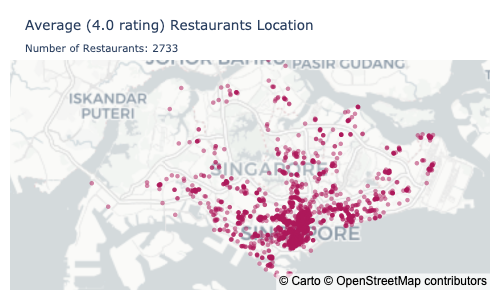

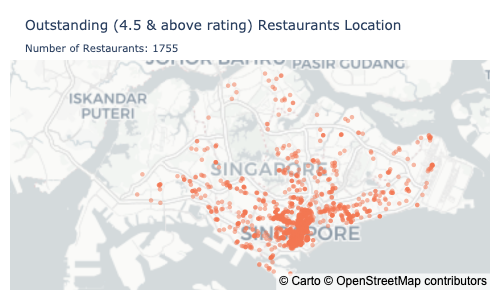

In [35]:
for i in [('Subpar', '3.5 & below', hex_colors[0]), ('Average', '4.0', hex_colors[2]), ('Outstanding', '4.5 & above', hex_colors[4])]:
    gdf_subset = gdf_restaurant[gdf_restaurant['overall_rating_categorical'] == i[0]]
    fig = px.scatter_mapbox(
        gdf_subset,
        lat=gdf_subset.geometry.y,
        lon=gdf_subset.geometry.x,
        width=500,
        height=300,
        center= {
            'lat': 1.35,
            'lon': 103.8
        },
        range_color=(1,5),
        hover_data=['station_name', 'station_line_color'],
        zoom=9.4 # 11.2 for CBD
    )

    fig.update_traces(
        marker=dict(
            size=5,
            opacity=0.5,
            color=i[2]
        )
    )

    fig.update_layout(
        title= f"<span style='font-size:80%'>{i[0]} ({i[1]} rating) Restaurants Location </span><br><span style='font-size:60%;'>Number of Restaurants: {len(gdf_subset)}</span>",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 60},
        mapbox_accesstoken=mapbox_token,
        mapbox= {'style': 'carto-positron'}
    )
    fig.show("png")

<strong>Observations:</strong>

- For restaurants of subpar, average and outstanding ratings, their geographical locations seem to be similarly distributed

#### Analyse Average Ratings of Regions

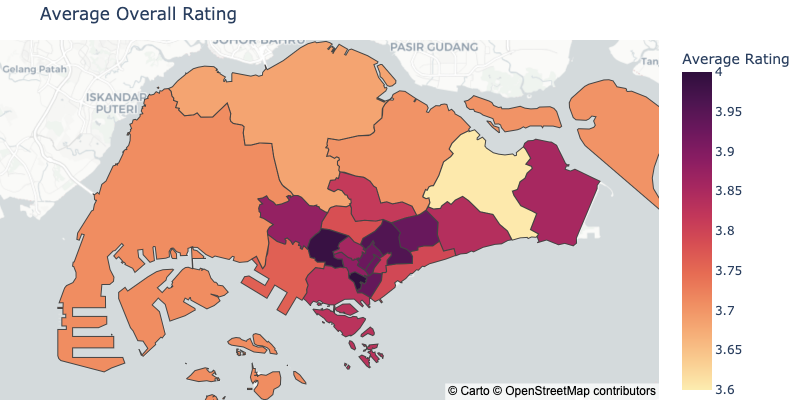

In [36]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='average_rating',
    color_continuous_scale='matter',
    range_color=(3.6,4.0),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'average_rating': 'Average Rating'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Average Overall Rating",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

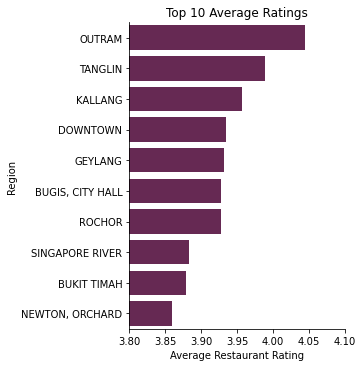

In [37]:
ax = sns.catplot(
    y = 'new_region_feature',
    x = 'average_rating',
    data = gdf_new_region.sort_values('average_rating', ascending=False).iloc[:10,:],
    kind='bar',
    color=hex_colors[1]
)

ax.fig.gca().set(xlim=(3.8,4.1))
ax.fig.gca().set_title("Top 10 Average Ratings")
ax.fig.gca().set_ylabel("Region")
ax.fig.gca().set_xlabel("Average Restaurant Rating")
plt.show()

<strong>Observations:</strong>

- From the map, it can be seen that Restaurants in the central region have the highers average rating.
- Among the regions with the top 10 average ratings, other than Bukit Timah, all the regions are located in the central/city districts

#### Analyse Average Number of Reviews of Regions
- As a measure of how popular/reputable the restaurant is

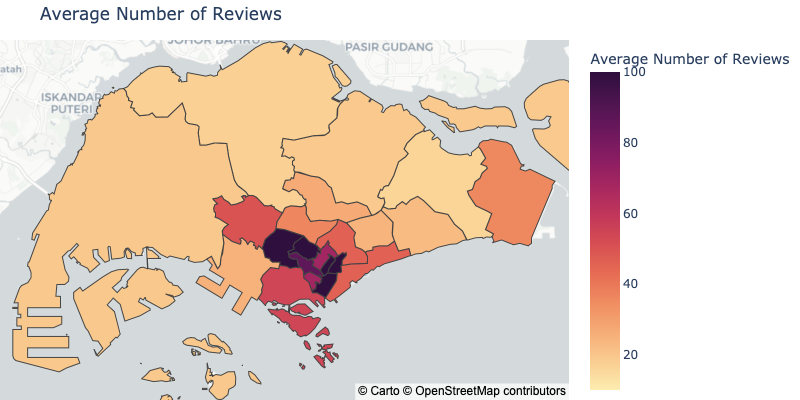

In [38]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='average_num_of_reviews',
    color_continuous_scale='matter',
    range_color=(10,100),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'average_num_of_reviews': 'Average Number of Reviews'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Average Number of Reviews",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

<strong>Observations:</strong>

- Like for the case of average rating, it can be seen that Restaurants in the central region have the highest average number of reviews, which show that restaurants in this areas are likely to be more known/popular

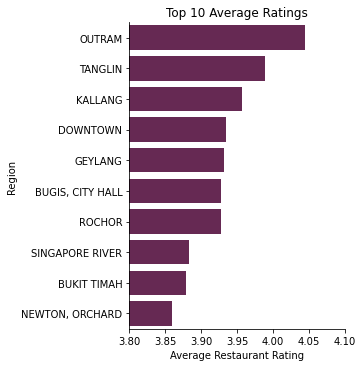

In [39]:
ax = sns.catplot(
    y = 'new_region_feature',
    x = 'average_rating',
    data = gdf_new_region.sort_values('average_rating', ascending=False).iloc[:10,:],
    kind='bar',
    color=hex_colors[1]
)

ax.fig.gca().set(xlim=(3.8,4.1))
ax.fig.gca().set_title("Top 10 Average Ratings")
ax.fig.gca().set_ylabel("Region")
ax.fig.gca().set_xlabel("Average Restaurant Rating")
plt.show()

### EDA on Walking Distance from Train Station

In [40]:
corr = gdf_restaurant[['walking_distance', 'overall_rating']].corr()
corr.style.background_gradient(cmap='RdYlGn')

,walking_distance,overall_rating
walking_distance,1.000000,0.021094
overall_rating,0.021094,1.000000


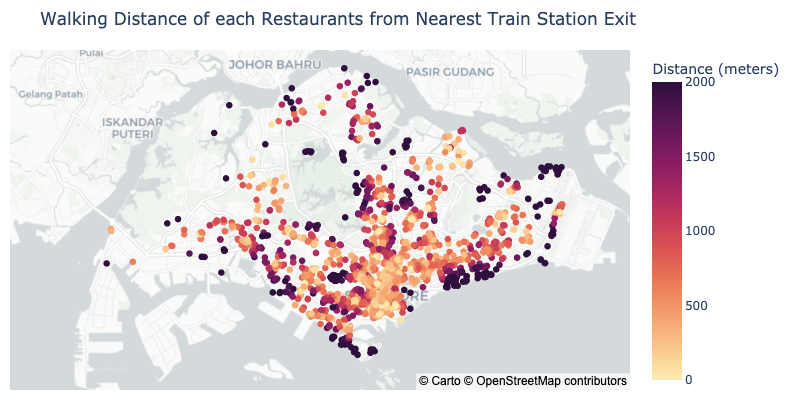

In [41]:
fig = px.scatter_mapbox(
    gdf_restaurant,
    lat=gdf_restaurant.geometry.y,
    lon=gdf_restaurant.geometry.x,
    color='walking_distance',
    # size='overall_rating',
    size_max=10,
    color_continuous_scale='matter',
    width=800,
    height=400,
    labels={
        "walking_distance": "Distance (meters)"
    },
    center= {
        'lat': 1.35,
        'lon': 103.8
    },
    range_color=(0,2000),
    hover_data=['station_name', 'station_line_color'],
    zoom=9.8 # 11.2 for CBD
)

fig.update_traces(
    marker=dict(
        size=7,
        # opacity=0.7
    )
)

fig.update_layout(
    title= "Walking Distance of each Restaurants from Nearest Train Station Exit",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

<strong>Observations:</strong>
- Restaurants located nearer to Coastal areas, such as East Coast Park and Sentosa, or Central Catchment areas have a longer walking distance
- Restaurants in CBD have low walking distance from the nearest train station

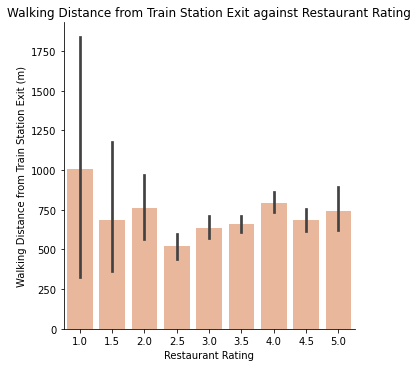

In [42]:
ax = sns.catplot(
    y = 'walking_distance',
    x = 'overall_rating',
    data = gdf_restaurant,
    kind='bar',
    color=hex_colors[5]
)
ax.fig.gca().set_title("Walking Distance from Train Station Exit against Restaurant Rating")
ax.fig.gca().set_ylabel("Walking Distance from Train Station Exit (m)")
ax.fig.gca().set_xlabel("Restaurant Rating")
plt.show()

<strong>Observations:</strong>
- Walking distance from train station seem to be indifferent for restaurants with rating higher than that of 1.5. However for restaurant with a very low rating of 1.0, walking distance from train station is very high.


In [43]:
df_station_name = gdf_restaurant.groupby(['station_name']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_station_name.columns = df_station_name.columns.droplevel(1)
df_station_name.reset_index(drop=False, inplace=True)
df_station_name.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)

df_station_line_color = gdf_restaurant.groupby(['station_line_color']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_station_line_color.columns = df_station_line_color.columns.droplevel(1)
df_station_line_color.reset_index(drop=False, inplace=True)
df_station_line_color.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)

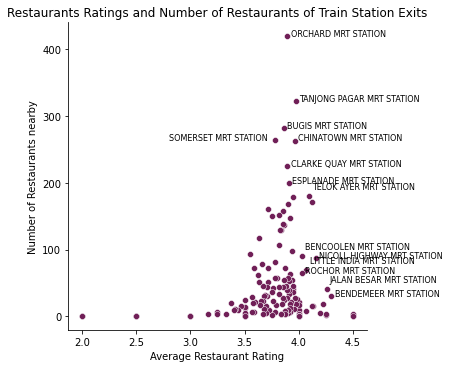

In [44]:
ax = sns.relplot(
    x = 'average_rating',
    y = 'num_of_restaurants',
    data = df_station_name,
    kind='scatter',
    color=hex_colors[1]
)
ax.fig.gca().set_title("Restaurants Ratings and Number of Restaurants of Train Station Exits")
ax.fig.gca().set_ylabel("Number of Restaurants nearby")
ax.fig.gca().set_xlabel("Average Restaurant Rating")

def label_point(x, y, val, ax, orientation="right"):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if orientation=="right":
            ax.text(point['x']+.03, point['y']+0.03, str(point['val']), size=8)
        elif orientation=="left":
            ax.text(point['x']-0.97, point['y']-0.03, str(point['val']), size=8)
        elif orientation=="top right":
            ax.text(point['x']+.03, point['y']+10, str(point['val']), size=8) 

label_left = ['SOMERSET MRT STATION']
label_right = ['ORCHARD MRT STATION', 'TANJONG PAGAR MRT STATION', 'BUGIS MRT STATION', 
'CHINATOWN MRT STATION', 'CLARKE QUAY MRT STATION', 'ESPLANADE MRT STATION', 'BENDEMEER MRT STATION', 'ROCHOR MRT STATION',
'NICOLL HIGHWAY MRT STATION', 'OUTRAM MRT STATION']

label_top_right = ['JALAN BESAR MRT STATION', 'LITTLE INDIA MRT STATION', 'BENCOOLEN MRT STATION', 'TELOK AYER MRT STATION']

for i in label_left:
    label_point(df_station_name[df_station_name['station_name'] == i].average_rating, 
    df_station_name[df_station_name['station_name'] == i].num_of_restaurants, 
    df_station_name[df_station_name['station_name'] == i].station_name, plt.gca(), orientation='left')

for i in label_right:
    label_point(df_station_name[df_station_name['station_name'] == i].average_rating, 
    df_station_name[df_station_name['station_name'] == i].num_of_restaurants, 
    df_station_name[df_station_name['station_name'] == i].station_name, plt.gca())

for i in label_top_right:
    label_point(df_station_name[df_station_name['station_name'] == i].average_rating, 
    df_station_name[df_station_name['station_name'] == i].num_of_restaurants, 
    df_station_name[df_station_name['station_name'] == i].station_name, plt.gca(), orientation='top right')

plt.show()

<strong>Observations:</strong>
- Looking at the Train Station Exits, the train station exits with above average restaurant average rating and a large number of restaurants are mostly located in the CBD regions like Orchard Road, Chinatown and Clarke Quay. These regions are likely to be more competitve.

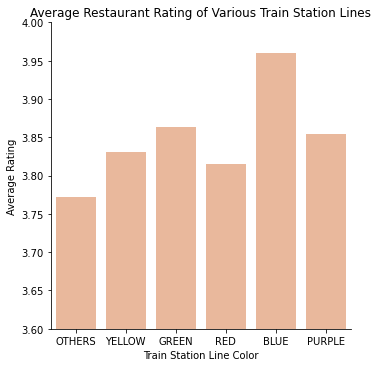

In [45]:
ax = sns.catplot(
    x = 'station_line_color',
    y = 'average_rating',
    data = df_station_line_color.sort_values('walking_distance', ascending=False),
    kind='bar',
    color=hex_colors[5]
)

ax.fig.gca().set(ylim=(3.6,4))
ax.fig.gca().set_title("Average Restaurant Rating of Various Train Station Lines")
ax.fig.gca().set_ylabel("Average Rating")
ax.fig.gca().set_xlabel("Train Station Line Color")
plt.show()

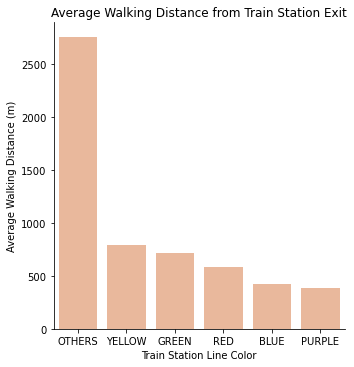

In [46]:
ax = sns.catplot(
    x = 'station_line_color',
    y = 'walking_distance',
    data = df_station_line_color.sort_values('walking_distance', ascending=False),
    kind='bar',
    color=hex_colors[5]
)

# ax.fig.gca().set(xlim=(3.8,4.1))
ax.fig.gca().set_title("Average Walking Distance from Train Station Exit")
ax.fig.gca().set_ylabel("Average Walking Distance (m)")
ax.fig.gca().set_xlabel("Train Station Line Color")
plt.show()

<strong>Observations:</strong>
- Restaurants near "OTHERS" Train Stations (such as LRT stations) have the longest walking distance from train station exits.
- BLUE and PURPLE lines (that serve the Downtown and Northeast regions) have the lowest average walking distance

### EDA on Restaurants Within Shopping Mall

In [47]:
gdf_restaurant['is_in_mall'] = gdf_restaurant['is_in_mall'].astype(object)

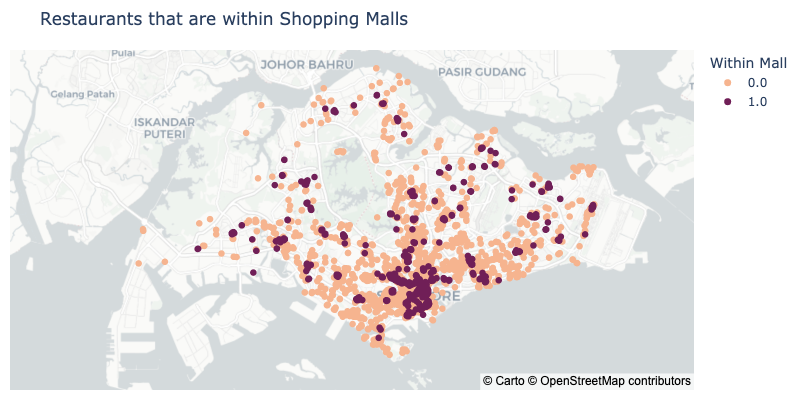

In [48]:
fig = px.scatter_mapbox(
    gdf_restaurant,
    lat=gdf_restaurant.geometry.y,
    lon=gdf_restaurant.geometry.x,
    size_max=10,
    color='is_in_mall',
    color_discrete_map={1: hex_colors[1], 0:hex_colors[5]},
    width=800,
    height=400,
    labels={
        "is_in_mall": "Within Mall"
    },
    center= {
        'lat': 1.35,
        'lon': 103.8
    },
    range_color=(0,2000),
    hover_data=['station_name', 'station_line_color'],
    zoom=9.8 # 11.2 for CBD
)

fig.update_traces(
    marker=dict(
        size=7,
        # opacity=0.7
    )
)

fig.update_layout(
    title= "Restaurants that are within Shopping Malls",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'},
    showlegend=True
)
fig.show("png")

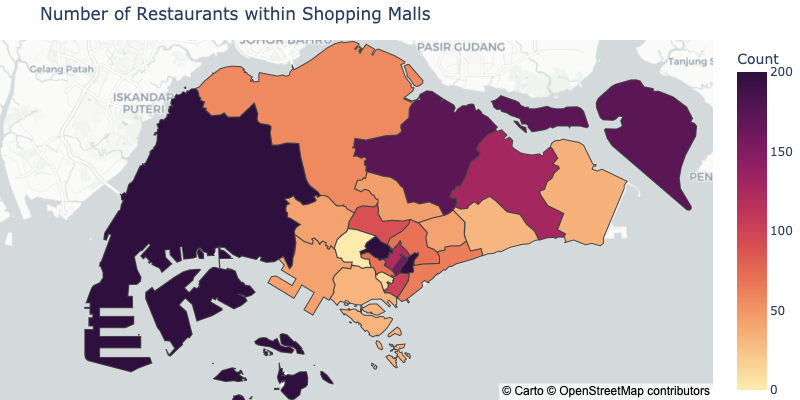

In [49]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='mall',
    color_continuous_scale='matter',
    range_color=(0,200),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'mall': 'Count'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants within Shopping Malls",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

<strong>Observations:</strong>
- West, North-East, Tampines/Pasir Ris/Paya Lebar and some CBD regions such as Bugis and Orchard has the most number of restaurants that are located within shopping malls
- Although there are number of restaurants within mall in west and north east region, from the scatter mapbox there are more malls in the Central District areas (each dot represents a mall location)

In [50]:
df_within_mall = gdf_restaurant.groupby(['mall']).agg({
    'url': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_within_mall.columns = df_within_mall.columns.droplevel(1)
df_within_mall.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)
df_within_mall.reset_index(drop=False, inplace=True)

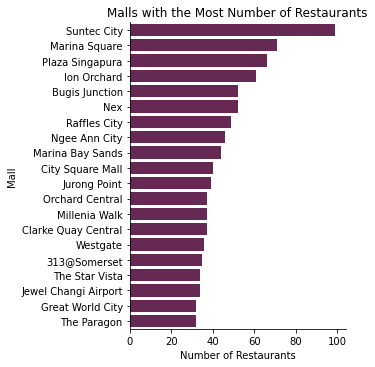

In [51]:
ax = sns.catplot(
    y = 'mall',
    x = 'num_of_restaurants',
    data = df_within_mall.sort_values('num_of_restaurants', ascending=False).iloc[:20,:],
    kind='bar',
    color=hex_colors[1]
)

# ax.fig.gca().set(xlim=(3.8,4.1))
ax.fig.gca().set_title("Malls with the Most Number of Restaurants")
ax.fig.gca().set_ylabel("Mall")
ax.fig.gca().set_xlabel("Number of Restaurants")
plt.show()

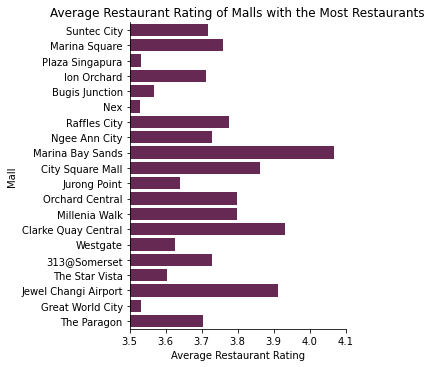

In [52]:
ax = sns.catplot(
    y = 'mall',
    x = 'average_rating',
    data = df_within_mall.sort_values('num_of_restaurants', ascending=False).iloc[:20,:],
    kind='bar',
    color=hex_colors[1]
)

ax.fig.gca().set(xlim=(3.5,4.1))
ax.fig.gca().set_title("Average Restaurant Rating of Malls with the Most Restaurants")
ax.fig.gca().set_ylabel("Mall")
ax.fig.gca().set_xlabel("Average Restaurant Rating")
plt.show()

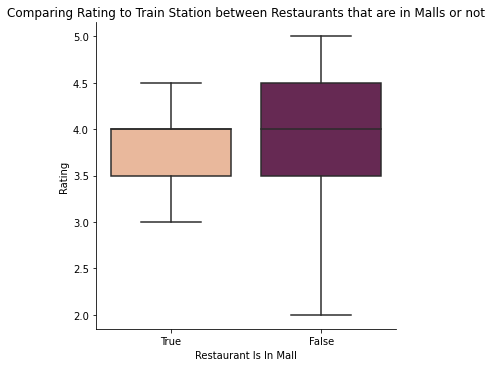

In [53]:
ax = sns.catplot(
    x = 'is_in_mall',
    y = 'overall_rating',
    data = gdf_restaurant,
    kind='box',
    order=[True, False],
    sym="",
    palette={True: hex_colors[5], False:hex_colors[1]}
)

ax.fig.gca().set_title("Comparing Rating to Train Station between Restaurants that are in Malls or not")
ax.fig.gca().set_ylabel("Rating")
ax.fig.gca().set_xlabel("Restaurant Is In Mall")
plt.show()

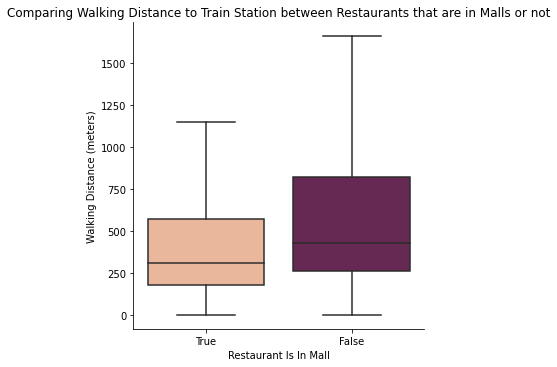

In [54]:
ax = sns.catplot(
    x = 'is_in_mall',
    y = 'walking_distance',
    data = gdf_restaurant,
    kind='box',
    order=[True, False],
    palette={True: hex_colors[5], False:hex_colors[1]},
    sym=""
)

ax.fig.gca().set_title("Comparing Walking Distance to Train Station between Restaurants that are in Malls or not")
ax.fig.gca().set_ylabel("Walking Distance (meters)")
ax.fig.gca().set_xlabel("Restaurant Is In Mall")
plt.show()

<strong>Observations:</strong>
- Wider spread of restaurant ratings for restaurants that are not within malls
- Overall higher ratings of restaurants that are not within malls than restaurants that are within malls
- Restaurants within malls have a lower walking distance from nearest train stations exits